# Segmenting and Clustering Neighborhoods in Toronto

In [1]:
import os 
from dotenv import load_dotenv

import requests
from bs4 import BeautifulSoup

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim    # convert an address into latitude and longitude

import folium    # map rendering library

## Download and Explore Dataset

### Scrape Data

Source link : https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [3]:
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
#soup = BeautifulSoup(r.text, "lxml")
#print(soup.prettify())

In [4]:
table = soup.find("table",{"class":"wikitable sortable"})

t_headers = []
for th in table.find_all("th"):
    # remove any newlines and extra spaces from left and right
    t_headers.append(th.text.replace('\n', ' ').strip())

table_data = []
for tr in table.tbody.find_all("tr"):
    t_row = {}
    for td, th in zip(tr.find_all("td"), t_headers):
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

print(table_data[1])

{'Postal Code': 'M1A', 'Borough': 'Not assigned', 'Neighbourhood': 'Not assigned'}


### Transform data into a *pandas* dataframe

In [5]:
df = pd.DataFrame(table_data)
df = df[df['Borough'] != 'Not assigned']
df['Neighbourhood'] = df.apply(lambda row: row['Borough'] if row['Neighbourhood'] == 'Not assigned' else row['Neighbourhood'], axis=1)
df.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
df.dropna(how='all', inplace=True)
df.head()

,Postal Code,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Load longitude and latitude data of neighborhoods

In [6]:
#import geocoder

In [7]:
#postal_code = 'M5G'

## initialize your variable to None
#lat_lng_coords = None

## loop until you get the coordinates
#while(lat_lng_coords is None):
#    g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#    lat_lng_coords = g.latlng

#latitude = lat_lng_coords[0]
#longitude = lat_lng_coords[1]

#print(latitude)
#print(longitude)

In [8]:
geospatial_df = pd.read_csv('data/Geospatial_Coordinates.csv')
geospatial_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge scraped dataset with geo-location data

In [9]:
df = pd.merge(df, geospatial_df, on='Postal Code', how='left')
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Make sure that the dataset has all 10 boroughs and 103 neighborhoods.

In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


### User geopy library to get the latitude and longitude values of Toronto.

In [11]:
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent='toronto_explorer')
location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude

print(f'The geographical coordinates of Toronto are {latitude}, {longitude}.')

The geographical coordinates of Toronto are 43.6534817, -79.3839347.


###  Create a map of Toronto with neighborhoods superimposed on top.

In [12]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = f'{neighborhood}, {borough}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#7528B9',
        fill=True,
        fill_color='#9F33FF',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_toronto)
    
map_toronto

### Define Foursquare Credentials and Version

In [13]:
load_dotenv()
CLIENT_ID = os.getenv("FS_CLIENT_ID")  # Foursquare Client ID
CLIENT_SECRET = os.getenv("FS_CLIENT_SECRET")  # Foursquare Client Secret
VERSION = '20201127' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### Explore the first neighborhood in our DataFrame

In [14]:
df.loc[0, 'Neighborhood']

'Parkwoods'

Get the neighborhood's latitude and longitude values:

In [15]:
neighborhood_latitude = df.loc[0, 'Latitude']
neighborhood_longitude = df.loc[0, 'Longitude']
neighborhood_name = df.loc[0, 'Neighborhood']

print(f'Latitude and longitude values of {neighborhood_name} are {neighborhood_latitude}, {neighborhood_longitude}.')

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


### Get the top 100 venues that are in Parkwoods within a radius of 1 kilometer.

First, let's create the GET request URL.
> `https://api.foursquare.com/v2/venues/`**search**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&query=`**QUERY**`&radius=`**RADIUS**`&limit=`**LIMIT**

In [16]:
radius = 1000
url = f'https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={neighborhood_latitude},{neighborhood_longitude}&v={VERSION}&radius={500}&limit={LIMIT}'
#url

In [17]:
results = requests.get(url).json()
#results

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        #categories_list = row['venue.categories']
        return None
    
    if len(categories_list):
        return categories_list[0]['name']
    else:
        return None

In [19]:
venues = results['response']['venues']

nearby_venues = pd.json_normalize(venues)

filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split('.')[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,TTC stop #8380,Bus Stop,43.752672,-79.326351
1,Brookbanks Park,Park,43.751976,-79.332140
2,Subway,Sandwich Place,43.760334,-79.326906
3,17 Brookbanks Drive,Residential Building (Apartment / Condo),43.752266,-79.332322
4,Towns On The Ravine,Residential Building (Apartment / Condo),43.754754,-79.332552


In [20]:
print(f'{nearby_venues.shape[0]} venues were returned by Foursquare.')

92 venues were returned by Foursquare.


## Explore Neighborhoods in Toronto

### Get Nearby Venues for all Neighborhoods

In [21]:
def get_nearby_venues(names, latitudes, longitudes, radius=500):
    venues = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        
        # Create an API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results
        ])
        
    nearby_venues = pd.DataFrame(item for venue in venues for item in venue)
    nearby_venues.columns = ['Neighborhood',
                          'Neighborhood Latitude',
                          'Neighborhood Longitude',
                          'Venue',
                          'Venue Latitude',
                          'Venue Longitude',   
                          'Venue Category']
    return nearby_venues

In [22]:
toronto_venues = get_nearby_venues(df['Neighborhood'], df['Latitude'], df['Longitude'])

In [23]:
print(toronto_venues.shape)
toronto_venues.head()

(2141, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [24]:
toronto_venues.groupby('Neighborhood').count()[['Venue']]

,Venue
Neighborhood,
Agincourt,5
"Alderwood, Long Branch",7
"Bathurst Manor, Wilson Heights, Downsview North",21
Bayview Village,4
"Bedford Park, Lawrence Manor East",22
Berczy Park,55
"Birch Cliff, Cliffside West",4
"Brockton, Parkdale Village, Exhibition Place",23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16


How many categories can be curated from all the returned values?

In [25]:
unique_cats = toronto_venues['Venue Category'].nunique()
print(f'There are {unique_cats} unique categories.')

There are 273 unique categories.


In [26]:
toronto_venues = toronto_venues[toronto_venues['Venue Category'] != 'Neighborhood']

## Analyze Each Neighborhood

In [27]:
# one-hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighborhood column back to the df
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [28]:
toronto_onehot.shape

(2137, 273)

### Analyze categories by grouping by neighborhood

Take the mean of the frequency of occurence of each category in all neighborhoods:

In [45]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [30]:
toronto_grouped.shape

(96, 273)

Print each neighborhood's the 5 most common venues:

In [31]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print('----' , hood , '----')
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print()

---- Agincourt ----
                       venue  freq
0  Latin American Restaurant   0.2
1             Clothing Store   0.2
2             Breakfast Spot   0.2
3                     Lounge   0.2
4               Skating Rink   0.2

---- Alderwood, Long Branch ----
            venue  freq
0     Pizza Place  0.29
1             Gym  0.14
2  Sandwich Place  0.14
3             Pub  0.14
4     Coffee Shop  0.14

---- Bathurst Manor, Wilson Heights, Downsview North ----
                       venue  freq
0                Coffee Shop  0.10
1                       Bank  0.10
2                   Pharmacy  0.05
3              Shopping Mall  0.05
4  Middle Eastern Restaurant  0.05

---- Bayview Village ----
                 venue  freq
0  Japanese Restaurant  0.25
1   Chinese Restaurant  0.25
2                 Bank  0.25
3                 Café  0.25
4    Accessories Store  0.00

---- Bedford Park, Lawrence Manor East ----
                     venue  freq
0              Coffee Shop  0.09
1          

                  venue  freq
0  Fast Food Restaurant  0.17
1           Pizza Place  0.08
2                   Gym  0.08
3    Chinese Restaurant  0.08
4        Breakfast Spot  0.08

---- Stn A PO Boxes ----
                 venue  freq
0          Coffee Shop  0.10
1   Italian Restaurant  0.04
2  Japanese Restaurant  0.03
3                  Pub  0.03
4                 Café  0.03

---- Studio District ----
                 venue  freq
0          Coffee Shop  0.08
1            Gastropub  0.06
2              Brewery  0.06
3                 Café  0.06
4  American Restaurant  0.06

---- Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park ----
                 venue  freq
0          Coffee Shop  0.14
1          Pizza Place  0.07
2                  Pub  0.07
3         Liquor Store  0.07
4  Fried Chicken Joint  0.07

---- The Annex, North Midtown, Yorkville ----
            venue  freq
0  Sandwich Place  0.16
1            Café  0.16
2     Coffee Shop  0.11
3  History Museum  0.05
4

In [32]:
def get_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append(f'{ind + 1}{indicators[ind]} Most Common Venue')
    except:
        columns.append(f'{ind + 1}th Most Common Venue')

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = get_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
    
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Latin American Restaurant,Clothing Store,Breakfast Spot,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Diner
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Gym,Sandwich Place,Coffee Shop,Pub,Dog Run,Dim Sum Restaurant,Diner,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Fried Chicken Joint,Chinese Restaurant,Bridal Shop,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant,Supermarket
3,Bayview Village,Café,Japanese Restaurant,Chinese Restaurant,Bank,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Greek Restaurant,Thai Restaurant,Liquor Store,Comfort Food Restaurant,Juice Bar,Butcher,Café


## Cluster Neighborhoods

Cluster neighborhoods by using *k-means clustering* algorithm with a list of number of clusters and compare their inertia values (lower inertia, better model):

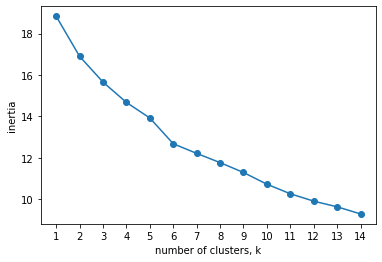

In [34]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', axis=1)

ks = range(1, 15)
inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(toronto_grouped_clustering)
    inertias.append(kmeans.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

With *elbow* method, we can choose k=6 as number of clusters.

In [35]:
# set number of clusters
num_clusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', axis=1)

kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(toronto_grouped_clustering)

kmeans.labels_[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Create a new dataframe that includes the top 10 venues for each neighborhood with their cluster labels.

In [36]:
# add cluster labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with df to add latitude&longitude for each neighborhood
#toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged = pd.merge(df, neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,Park,Food & Drink Shop,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Intersection,Pizza Place,French Restaurant,Hockey Arena,Coffee Shop,Portuguese Restaurant,Donut Shop,Diner,Discount Store,Distribution Center
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Beer Store,Brewery,Shoe Store
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Yoga Studio,Sushi Restaurant,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Restaurant,Café,Chinese Restaurant


In [37]:
toronto_merged.groupby('Cluster Labels')['Neighborhood'].nunique()

Cluster Labels
0     9
1    82
2     1
3     1
4     1
5     2
Name: Neighborhood, dtype: int64

Visualize clusters:

In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color = rainbow[cluster-1],
        fill_opacity=0.7
    ).add_to(map_clusters)

map_clusters

## Examine Clusters

### Cluster 1

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Park,Food & Drink Shop,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
20,Caledonia-Fairbanks,Park,Women's Store,Pool,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
34,"East Toronto, Broadview North (Old East York)",Park,Convenience Store,Intersection,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
50,"North Park, Maple Leaf Park, Upwood Park",Park,Construction & Landscaping,Bakery,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
59,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
62,Weston,Park,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
64,York Mills West,Park,Convenience Store,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
83,"Milliken, Agincourt North, Steeles East, L'Amo...",Intersection,Park,Playground,Bakery,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
89,Rosedale,Park,Playground,Trail,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant


### Cluster 2

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Intersection,Pizza Place,French Restaurant,Hockey Arena,Coffee Shop,Portuguese Restaurant,Donut Shop,Diner,Discount Store,Distribution Center
2,"Regent Park, Harbourfront",Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Beer Store,Brewery,Shoe Store
3,"Lawrence Manor, Lawrence Heights",Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service
4,"Queen's Park, Ontario Provincial Government",Coffee Shop,Yoga Studio,Sushi Restaurant,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Restaurant,Café,Chinese Restaurant
6,Don Mills,Gym,Beer Store,Coffee Shop,Japanese Restaurant,Caribbean Restaurant,Clothing Store,Supermarket,Discount Store,Restaurant,Café
7,Don Mills,Gym,Beer Store,Coffee Shop,Japanese Restaurant,Caribbean Restaurant,Clothing Store,Supermarket,Discount Store,Restaurant,Café
8,"Parkview Hill, Woodbine Gardens",Pizza Place,Pharmacy,Gastropub,Gym / Fitness Center,Pet Store,Intersection,Breakfast Spot,Athletics & Sports,Bus Line,Bank
9,"Garden District, Ryerson",Clothing Store,Coffee Shop,Café,Japanese Restaurant,Cosmetics Shop,Bubble Tea Shop,Fast Food Restaurant,Furniture / Home Store,Bookstore,Middle Eastern Restaurant
10,Glencairn,Park,Pizza Place,Bakery,Japanese Restaurant,Pub,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant
12,"Rouge Hill, Port Union, Highland Creek",Construction & Landscaping,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store


### Cluster 3

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,"York Mills, Silver Hills",Martial Arts School,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant


### Cluster 4

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"West Deane Park, Princess Gardens, Martin Grov...",Print Shop,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio,Dim Sum Restaurant


### Cluster 5

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"Malvern, Rouge",Fast Food Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Women's Store


### Cluster 6

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,"Humberlea, Emery",Baseball Field,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Field
98,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Construction & Landscaping,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
